## 1. Import packages

In [1]:
import numpy as np

from astropy.modeling import models
from astropy.table import Table

import matplotlib.pyplot as plt

## 2. Read FITS image file

FITS file includes one or more layers, and each layer contains different perspective of the observation such as observed values, error, mask, exposure time, etc.

Each layer consists of data and header. A header contains the descriptions of the data such as what the data is, when the observation was taken, the status of the instrument and telescope, and the modification history.

### Read FITS file

In [2]:
from astropy.io import fits

In [3]:
hdu = fits.open('SLT_EPIC210651981.fits')

### Inspect the structure of this FITS file

In [4]:
hdu.info()

Filename: SLT_EPIC210651981.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     140   (1024, 1024)   float64   


### Display the header of the zeroth layer

In [5]:
header = hdu[0].header

In [6]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
DATE-OBS= '2021-10-28T14:33:56' / ISO-8601 time of observation                  
TIME-OBS= '14:33:56'           / [old format] UTC time of exposure start        
EXPTIME =   1.20000000000E+002 / [sec] Duration of exposure                     
EXPOSURE=   1.20000000000E+002 / [sec] Duration of exposure                     
SET-TEMP=  -80.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -79.247001647949219 /CCD temperature at start of exposure in C       
XPIXSZ  =   27.000000000000000 /Pixel Width in microns (after binning)          
YPIXSZ  =   27.0000000000000

### Create an Astropy world coordinate system (WCS) object with header

WCS object describes the relation between the pixel coordinate (x, y) and the equtorial coordinate (RA, Dec)

In [7]:
from astropy.wcs import WCS

In [8]:
wcs = WCS(header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [9]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 67.1152117161  17.6782701415  
CRPIX : 512.0  512.0  
PC1_1 PC1_2  : -0.000438733323539  0.0  
PC2_1 PC2_2  : 0.0  0.000438646991722  
CDELT : 1.0  1.0  
NAXIS : 1024  1024

### Assign the data to the variable `img`

In [10]:
img = hdu[0].data

## 2.1 Plot the image

### Use the `imshow` function of matplotlib pyplot to plot the image in two dimension

In [11]:
import matplotlib.pyplot as plt

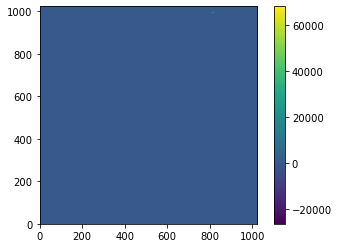

In [12]:
# Set origin='lower' to correct the direction of the image to what we see in the sky
plt.imshow(img, origin='lower')
# Plot color bar
plt.colorbar()
# Show the image
plt.show()

### The extreme values affect the color bar of the image so we need to do normalization

In [13]:
from astropy.visualization import simple_norm

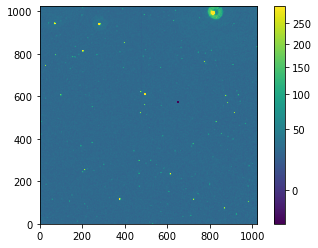

In [14]:
# Only 99.9% of the data in the middle (excluding the 0.01% extreme values) are considered.
norm = simple_norm(img, stretch='sqrt', percent=99.9)

plt.imshow(img, origin='lower', norm=norm)
plt.colorbar()
plt.show()

### Enlarge the image for better looking

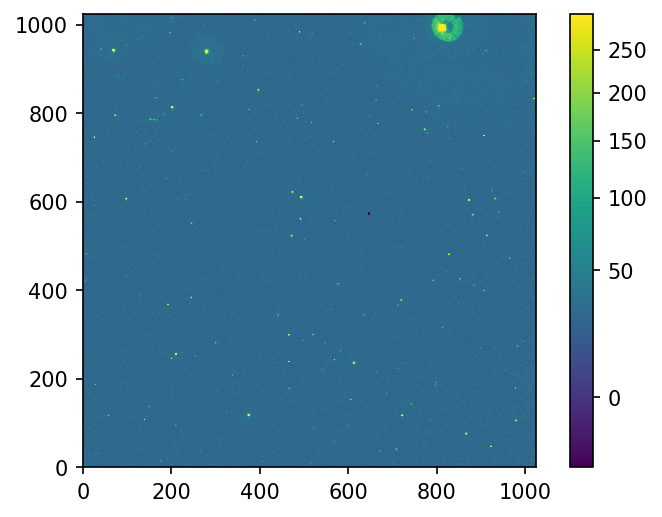

In [15]:
# You can change the `dpi` value to enlarge or reduce the image. Default: 100
plt.figure(dpi=150)

norm = simple_norm(img, stretch='sqrt', percent=99.9)
plt.imshow(img, origin='lower', norm=norm)
plt.colorbar()
plt.show()

### Display in `(RA, Dec)` instead of `(x, y)`

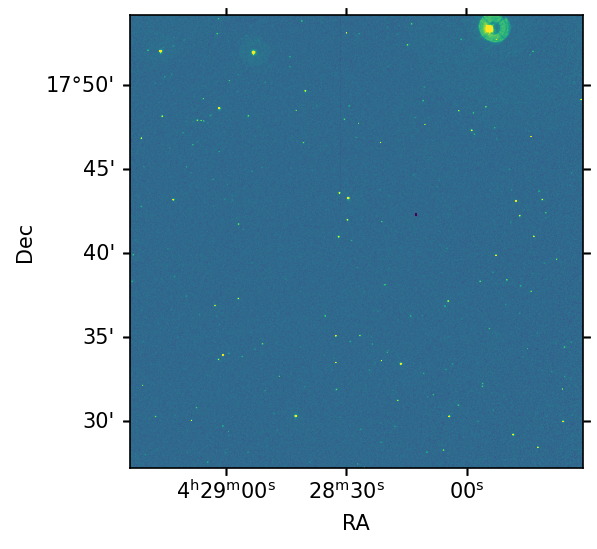

In [16]:
plt.figure(dpi=150)

ax = plt.subplot(projection=wcs)

norm = simple_norm(img, stretch='sqrt', percent=99.9)
ax.imshow(img, origin='lower', norm=norm)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

### 2.2 Analyze the background noise of the image

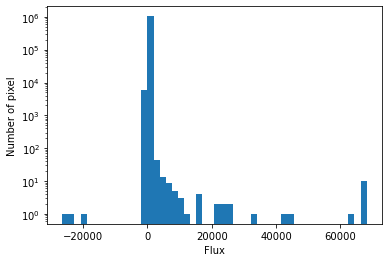

In [17]:
# We can use `img.ravel()` or `img.flatten()` to flatten the 2d image to 1d array.
# plt.hist to plot histogram
plt.hist(img.ravel(), bins=50)
# Set the scale of y axis to log scale
plt.yscale('log')
plt.xlabel('Flux')
plt.ylabel('Number of pixel')
plt.show()

In [18]:
np.mean(img), np.median(img), np.std(img)

(30.559126497851732, 28.608288773735573, 243.05107168659922)

In [19]:
np.nanmean(img), np.nanmedian(img), np.nanstd(img)

(30.559126497851732, 28.608288773735573, 243.05107168659922)

### To analyze the background noise, firstly, we need to filter out the non-noise signal

## 2.2.1 Method 1：Mask the astronomical signal

### Make a source mask

In [20]:
from photutils.segmentation import make_source_mask

In [21]:
# Make a source mask of sources above 3 sigma and with at least 5 contiguous pixels.
mask = make_source_mask(img, nsigma=3, npixels=5)

In [22]:
# Copy `img` to `masked_img`
masked_img = img.copy()
# Change the values of the masked pixels to NaN (Not a Number)
masked_img[mask] = np.nan

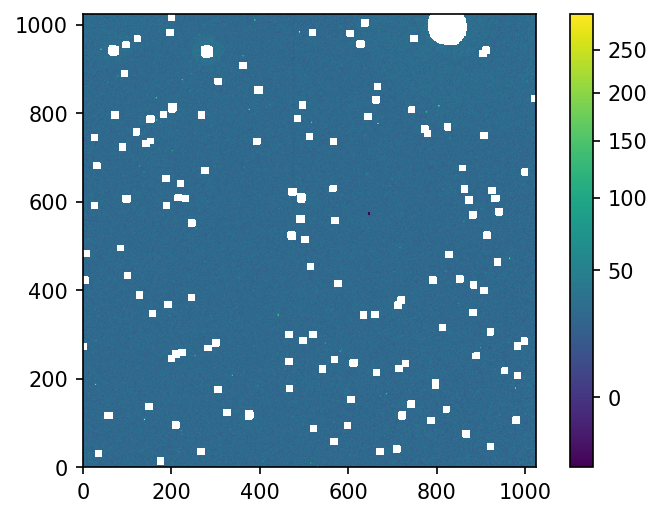

In [23]:
plt.figure(dpi=150)
norm = simple_norm(img, stretch='sqrt', percent=99.9)
plt.imshow(masked_img, origin='lower', norm=norm)
plt.colorbar()
plt.show()

In [24]:
# The mean, median, and stddev of the original image
np.nanmean(img), np.nanmedian(img), np.nanstd(img)

(30.559126497851732, 28.608288773735573, 243.05107168659922)

In [25]:
# The mean, median, and stddev of the masked image
np.nanmean(masked_img), np.nanmedian(masked_img), np.nanstd(masked_img)

(28.566238723164062, 28.501767554622624, 42.3019293300475)

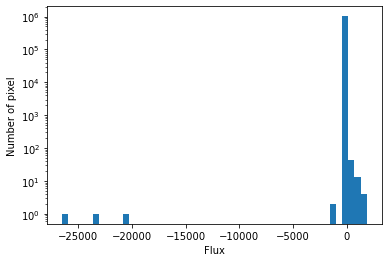

In [26]:
plt.hist(masked_img.ravel(), bins=50)
plt.yscale('log')
plt.xlabel('Flux')
plt.ylabel('Number of pixel')
plt.show()

## 2.2.2 Method 2：Use `sigma clip` to filter out the extreme values

In [27]:
from astropy.stats import sigma_clipped_stats

In [28]:
results = sigma_clipped_stats(img, sigma=3, maxiters=5)
results

(28.612509545021886, 28.529466980124255, 10.483914948456308)

In [29]:
help(sigma_clipped_stats)

Help on function sigma_clipped_stats in module astropy.stats.sigma_clipping:

sigma_clipped_stats(data, mask=None, mask_value=None, sigma=3.0, sigma_lower=None, sigma_upper=None, maxiters=5, cenfunc='median', stdfunc='std', std_ddof=0, axis=None, grow=False)
    Calculate sigma-clipped statistics on the provided data.
    
    Parameters
    ----------
    data : array-like or `~numpy.ma.MaskedArray`
        Data array or object that can be converted to an array.
    
    mask : `numpy.ndarray` (bool), optional
        A boolean mask with the same shape as ``data``, where a `True`
        value indicates the corresponding element of ``data`` is masked.
        Masked pixels are excluded when computing the statistics.
    
    mask_value : float, optional
        A data value (e.g., ``0.0``) that is ignored when computing the
        statistics. ``mask_value`` will be masked in addition to any
        input ``mask``.
    
    sigma : float, optional
        The number of standard deviat

### Check the sigma-clipped image

In [30]:
from astropy.stats import sigma_clip

In [31]:
clipped_img = sigma_clip(img)

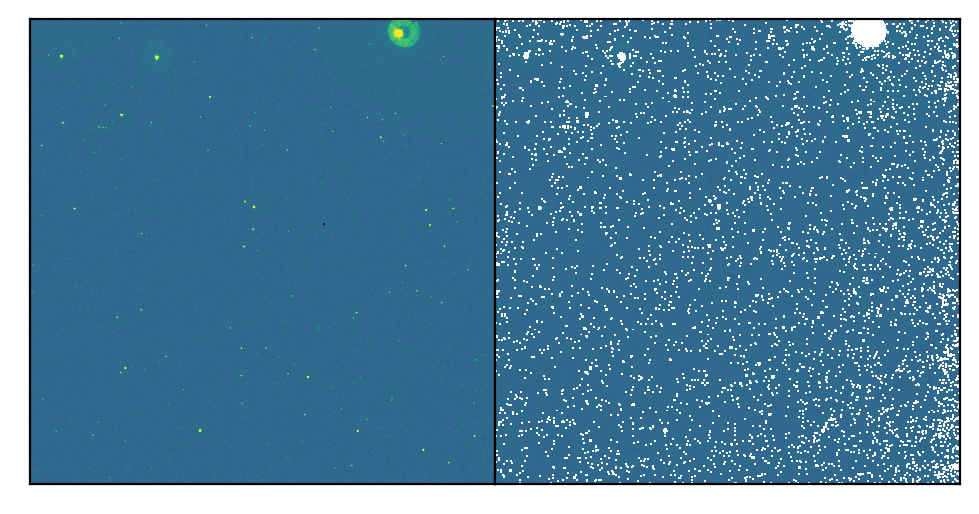

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=200, sharey=True)

ax[0].imshow(img, origin='lower', norm=norm)
ax[1].imshow(clipped_img, origin='lower', norm=norm)

plt.subplots_adjust(wspace=0)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
plt.show()

### Check the distribution of the background noise

In [33]:
from astropy.modeling import models

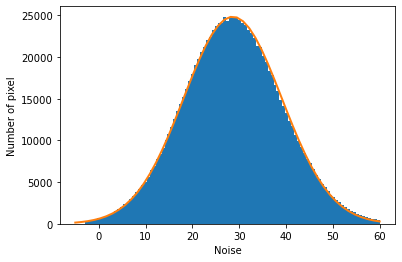

In [34]:
# dat[0]: the number of pixel in each bin
# dat[1]: bin edges
dat = plt.hist(clipped_img.ravel(), bins=100)

x = np.linspace(-5, 60)
gfunc = models.Gaussian1D(amplitude=dat[0].max(), mean=results[0], stddev=results[2])
plt.plot(x, gfunc(x), lw=2)

plt.xlabel('Noise')
plt.ylabel('Number of pixel')
plt.show()

## 3. Read FITS table

### FITS can also be used to store tables.

In [35]:
from astropy.table import Table

In [36]:
cat = Table.read('SLT_EPIC210651981.cat')

In [37]:
# Check how many rows in this table
len(cat)

207

In [38]:
cat[:5]

FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_ISOCOR,FLUXERR_ISOCOR,MAG_ISOCOR,MAGERR_ISOCOR,FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,ALPHAPEAK_SKY,DELTAPEAK_SKY,ALPHAPEAK_J2000,DELTAPEAK_J2000,X_IMAGE,Y_IMAGE,FWHM_IMAGE
ct,ct,mag,mag,ct,ct,mag,mag,ct,ct,mag,mag,deg,deg,deg,deg,pix,pix,pix
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32
963.1185,48.97,-7.4592,0.0552,1120.584,73.83878,-7.6236,0.0716,1067.533,77.42797,-7.5710,0.0788,139.4895876,-30.4311201,139.4895876,-30.4311201,176.1513,13.8537,1.98
661.4892,40.1856,-7.0513,0.0660,764.0114,59.69382,-7.2077,0.0849,667.3184,54.79484,-7.0608,0.0892,150.9055007,1.9621331,150.9055007,1.9621331,515.0859,9.7659,1.14
1666.427,49.52102,-8.0545,0.0323,1728.268,55.48754,-8.0940,0.0349,1681.722,57.58463,-8.0644,0.0372,151.5078854,3.5217116,151.5078854,3.5217116,530.1179,2.0299,0.00
1501.367,55.31121,-7.9412,0.0400,1644.031,72.61776,-8.0398,0.0480,1509.995,71.32629,-7.9474,0.0513,338.9467727,15.8346298,338.9467727,15.8346298,637.1408,1004.3973,1.69
1465998,1263.566,-15.4153,0.0009,1483164,1306.413,-15.4280,0.0010,1375738,1189.053,-15.3463,0.0009,332.6233457,32.5169582,332.6233457,32.5169582,814.8290,993.8477,7.64


In [39]:
cat['FLUX_AUTO'][:5]

1067.533
667.3184
1681.722
1509.995
1375738


### Check what `ct` is

In [40]:
from astropy import units as u

In [41]:
u.ct.long_names

['count']

In [42]:
angle = 30 * u.arcsec
angle

<Quantity 30. arcsec>

In [43]:
angle

<Quantity 30. arcsec>

In [44]:
angle.value, angle.unit

(30.0, Unit("arcsec"))

In [45]:
angle.to(u.arcmin)

<Quantity 0.5 arcmin>

In [46]:
flux = 3 * u.Jy

In [47]:
flux.to(u.erg / u.s / u.Hz / u.cm**2)

<Quantity 3.e-23 erg / (cm2 Hz s)>

### Plot circles on the sources

In [48]:
# We need to minus one here because the index of Python starts from 0 rather than 1.
# The table was generated by SExtractor, which starts counting from 1.
x_img, y_img = cat['X_IMAGE'] - 1, cat['Y_IMAGE'] - 1

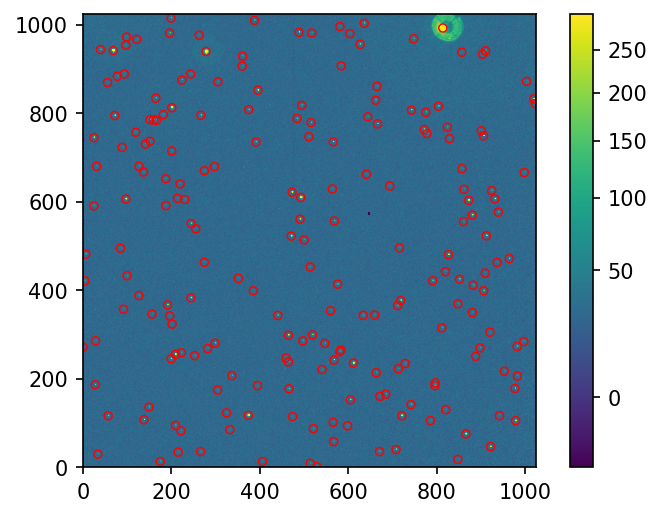

In [49]:
plt.figure(dpi=150)

norm = simple_norm(img, stretch='sqrt', percent=99.9)
plt.imshow(img, origin='lower', norm=norm)
plt.colorbar()

plt.scatter(x_img, y_img, s=15, ec='r', fc='none', lw=0.7)

plt.show()

### Covert `(x, y)` to `(RA, Dec)` with `WCS`

In [50]:
xy = np.stack([x_img, y_img], axis=1)

In [51]:
xy[:5]

array([[ 175.15126  ,   12.853669 ],
       [ 514.08594  ,    8.765878 ],
       [ 529.1179   ,    1.0298934],
       [ 636.1408   , 1003.39734  ],
       [ 813.829    ,  992.84766  ]], dtype=float32)

### The `1` here is to tell the function the `(x, y)` we feed here starts counting from 1.

In [52]:
# Because 
radec = wcs.all_pix2world(xy, 1)
radec[:5]

array([[67.2701343 , 17.45926223],
       [67.11425236, 17.4575291 ],
       [67.1073391 , 17.45413563],
       [67.05797892, 17.89381073],
       [66.97606293, 17.88914217]])

### We can also plot using `(RA, Dec)`

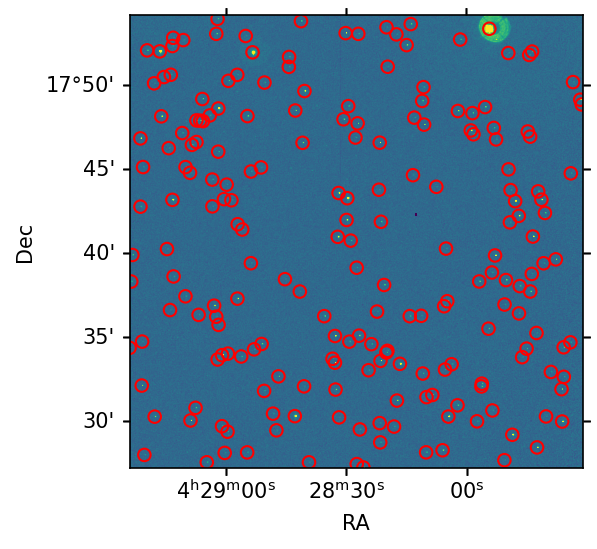

In [53]:
fig = plt.figure(dpi=150)
ax = plt.subplot(projection=wcs)
norm = simple_norm(img, stretch='sqrt', percent=99.9)
ax.imshow(img, origin='lower', norm=norm)

ax.scatter(radec[:, 0], radec[:, 1], ec='r', fc='none', transform=ax.get_transform('fk5'))

ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.show()

### Another way is to plot with `SkyCoord` objects

In [54]:
from astropy.coordinates import SkyCoord

In [55]:
sc_radec = SkyCoord(ra=radec[:, 0], dec=radec[:, 1], unit='deg', frame='fk5')

In [56]:
sc_radec[:5]

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(67.2701343 , 17.45926223), (67.11425236, 17.4575291 ),
     (67.1073391 , 17.45413563), (67.05797892, 17.89381073),
     (66.97606293, 17.88914217)]>

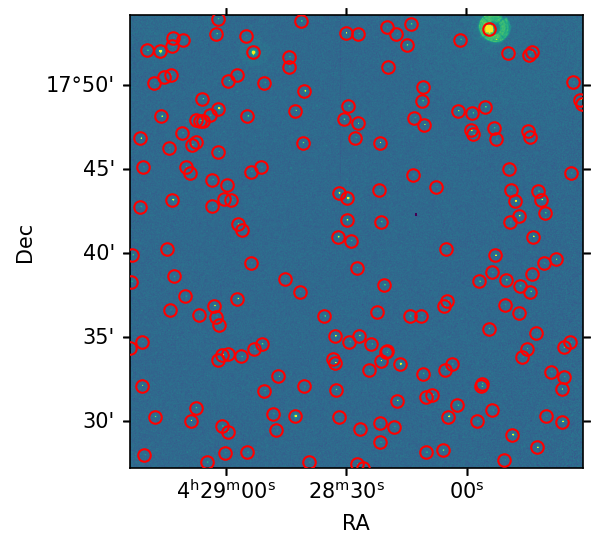

In [57]:
fig = plt.figure(dpi=150)
ax = plt.subplot(projection=wcs)
norm = simple_norm(img, stretch='sqrt', percent=99.9)
ax.imshow(img, origin='lower', norm=norm)

ax.plot_coord(sc_radec, 'o', mec='r', mfc='none', ms=6)

ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.show()

### Convert `(RA, Dec)` to `hmsdms` using SkyCoord

In [58]:
sc_radec.to_string('hmsdms')[:5]

['04h29m04.83223109s +17d27m33.34401142s',
 '04h28m27.42056747s +17d27m27.10475097s',
 '04h28m25.7613829s +17d27m14.88826773s',
 '04h28m13.91494081s +17d53m37.7186318s',
 '04h27m54.25510271s +17d53m20.91182172s']

In [59]:
sc_radec.to_string('hmsdms', sep=':')[:5]

['04:29:04.83223109 +17:27:33.34401142',
 '04:28:27.42056747 +17:27:27.10475097',
 '04:28:25.7613829 +17:27:14.88826773',
 '04:28:13.91494081 +17:53:37.7186318',
 '04:27:54.25510271 +17:53:20.91182172']